In [1]:
#!/usr/bin/env python
import torch
import various_data_functions
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
N=10**3

In [ ]:
#Base functions adapted from the practicals
def train_model(model, train_input, train_target,train_classes, mini_batch_size, test_input=None, test_target=None, crit=nn.CrossEntropyLoss, eta = 1e-3, nb_epochs = 50,print_=False, store_loss = False, aux_factor=1, store_error=False, checkpoint_name=None):
    criterion = crit()
    optimizer = optim.Adam(model.parameters(), lr=eta)
    stored_loss = []
    stored_error = []
    nb_epochs_finished = 0
    if checkpoint_name!=None:
        try:
            checkpoint = torch.load(checkpoint_name)
            nb_epochs_finished = checkpoint['nb_epochs_finished']
            model.load_state_dict(checkpoint['model_state'])
            optimizer.load_state_dict(checkpoint['optimizer_state'])
            if print_:
                print(f'Checkpoint loaded with {nb_epochs_finished} epochs finished.')
            stored_loss=checkpoint['stored_loss']
            if len(stored_loss)>nb_epochs*3:
                stored_loss=stored_loss[0:nb_epochs*3]
            stored_error=checkpoint['stored_error']
            if len(stored_error)>nb_epochs:
                stored_error=stored_error[0:nb_epochs]
        except FileNotFoundError:
            if print_:
                print('Starting from scratch.')
        except:
            print('Error when loading the checkpoint.')
            exit(1)
    
    for e in range(nb_epochs_finished,nb_epochs):
        acc_loss = 0
        acc_loss1 = 0
        acc_loss2 = 0
        acc_loss3 = 0
        permuted_index = torch.randperm(train_input.size()[0])
        train_input_shuffled = train_input[permuted_index]
        train_target_shuffled = train_target[permuted_index]
        train_classes_shuffled = train_classes[permuted_index]
        for b in range(0, train_input.size(0), mini_batch_size):
            output,aux_output = model(train_input_shuffled.narrow(0, b, mini_batch_size))
            if crit==nn.MSELoss:
                loss1 = criterion(output[:,1], train_target_shuffled.narrow(0, b, mini_batch_size))
                loss2 = criterion(torch.argmax(aux_output[:,0:9],dim=1), train_classes_shuffled[:,0].narrow(0, b, mini_batch_size))
                loss3 = criterion(torch.argmax(aux_output[:,10:19],dim=1), train_classes_shuffled[:,1].narrow(0, b, mini_batch_size))
                loss = loss1 + loss2 + loss3
                print('|| loss1 req grad =', loss1.requires_grad, '|| loss2 req grad =',loss2.requires_grad,'|| loss3 req grad =', loss3.requires_grad)
            elif crit==nn.CrossEntropyLoss:
                loss1 = criterion(output, train_target_shuffled.narrow(0, b, mini_batch_size))
                loss2 = criterion(aux_output[:,:10], train_classes_shuffled[:,0].narrow(0, b, mini_batch_size))
                loss3 = criterion(aux_output[:,10:], train_classes_shuffled[:,1].narrow(0, b, mini_batch_size))
                loss = loss1 + aux_factor*(loss2 + loss3)
            else:
                print("Loss not implemented")
            acc_loss = acc_loss + loss.item()
            acc_loss1 = acc_loss1 + loss1.item()
            acc_loss2 = acc_loss2 + loss2.item()
            acc_loss3 = acc_loss3 + loss3.item()
                
            model.zero_grad()
            loss.backward()
            optimizer.step()
        if store_loss:
            stored_loss += [[acc_loss1], [acc_loss2], [acc_loss3]]
        if store_error:
            stored_error +=[compute_nb_errors(model, test_input, test_target, mini_batch_size)]
        if print_:
            print(e, 'tot loss', acc_loss, 'loss1', acc_loss1, 'loss2', acc_loss2, 'loss3', acc_loss3)
        if checkpoint_name!=None:
                checkpoint = {'nb_epochs_finished': e + 1,'model_state': model.state_dict(),'optimizer_state': optimizer.state_dict(),'stored_loss':stored_loss,'stored_error':stored_error}
                torch.save(checkpoint, checkpoint_name)
                
    return torch.tensor(stored_loss),torch.tensor(stored_error)
    
def compute_nb_errors(model, input, target, mini_batch_size=100):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output , aux_output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k]!=predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

def run_many_times(model,crit=nn.CrossEntropyLoss,mini_batch_size=100,n=10,print_=True,eta=1e-3,nb_epochs=25,aux_factor=0,shuffle=True, store_error=False,checkpoint_name=None):
    average_error=0
    losses=torch.empty(0,nb_epochs,3)
    errors=torch.empty(0,nb_epochs)
    for i in range(n):
        m=model()
        train_input,train_target,train_classes,test_input,test_target,test_classes=various_data_functions.data(N,True,False,nn.CrossEntropyLoss,shuffle=shuffle)
        if checkpoint_name!=None:
            checkpoint_name_spec=checkpoint_name+'try_'+str(i)+'.pth'
        else:
            checkpoint_name_spec=None
        new_losses,new_errors=train_model(m, train_input, train_target,train_classes,mini_batch_size,test_input=test_input, test_target=test_target,crit=crit,eta=eta,nb_epochs=nb_epochs,aux_factor=aux_factor,store_loss=True,store_error=store_error,checkpoint_name=checkpoint_name_spec)
        new_losses=new_losses.view(1,nb_epochs, 3)
        if store_error:
            new_errors= new_errors.view(1,nb_epochs)
            errors = torch.cat((errors,new_errors),0)
        if print_:
            losses = torch.cat((losses, new_losses), 0)
            nb_test_errors = compute_nb_errors(m, test_input, test_target, mini_batch_size)
            print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))
            average_error+=(100 * nb_test_errors) / test_input.size(0)
    if print_:
        print("Average error: "+str(average_error/n))
        avg_losses=torch.sum(losses,0)/n
        mod=int(torch.floor(torch.Tensor([nb_epochs/25])))
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        x_lab=torch.arange(nb_epochs)
        x_labels=x_lab[x_lab%mod==0].detach().numpy()
        ax0.errorbar(x_labels, avg_losses[x_lab%mod==0,0].detach().numpy(), yerr=torch.std(losses[:,:,0],0)[x_lab%mod==0].detach().numpy(), fmt='-o')
        ax0.set_title('evolution of the cross entropy loss')
        ax1.errorbar(x_labels, avg_losses[x_lab%mod==0,1].detach().numpy(), yerr=torch.std(losses[:,:,1],0)[x_lab%mod==0].detach().numpy(), fmt='o')
        ax1.errorbar(x_labels, avg_losses[x_lab%mod==0,2].detach().numpy(), yerr=torch.std(losses[:,:,2],0)[x_lab%mod==0].detach().numpy(), fmt='o')
        ax1.set_title('evolution of the auxiliary losses')
        plt.show()
    if store_error:
        return errors

def n_params(model):
    n = 0
    for params in model.parameters():
        n += params.numel()
    return n

def big_error_plot(models,model_names,n=50,nb_epochs=100,eta=1e-3,div=25,name="big_error_plot.png",aux_factor=1):
    x_lab=torch.arange(nb_epochs)
    mod=int(torch.floor(torch.Tensor([nb_epochs/div])))
    x_labels=x_lab[x_lab%mod==0].detach().numpy()
    for i in range(len(models)):
        print("Starting model " + model_names[i])
        errors=run_many_times(models[i],crit=nn.CrossEntropyLoss,mini_batch_size=100,n=n,print_=False,eta=eta,nb_epochs=nb_epochs,aux_factor=aux_factor,shuffle=True, store_error=True,checkpoint_name='checkpoints/'+model_names[i]+'_'+str(aux_factor).replace('.','')+'_')
        plt.errorbar(x_labels,errors.mean(dim=0)[x_lab%mod==0].detach().numpy(),yerr=torch.std(errors,dim=0)[x_lab%mod==0].detach().numpy(),fmt='o')
        print('Mean number of errors after '+str(nb_epochs)+' epochs of training: '+str(errors.mean(dim=0)[-1])+' out of 1000 test samples with a standard deviation of '+str(torch.std(errors,dim=0)[-1]))
    plt.ylabel('Number of errors')
    plt.xlabel('Number of epochs')
    plt.legend(model_names)
    plt.savefig(name,bbox_inches='tight')
    plt.show()

In [3]:
class NetGroups3328Aux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 208, kernel_size=3,groups=2)
        self.fc1 = nn.Linear(3328, 20)
        self.fc2 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        aux_output = F.softmax(self.fc1(x.view(-1, 3328)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 3328)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output

class NetGroups512_128Aux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3,groups=2)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(self.fc1(x.view(-1, 512)))
        x = F.relu(self.fc2(x))
        aux_output = F.softmax(x, dim=1)
        output = F.softmax(self.fc3(x),dim=1)
        return output, aux_output

class NetGroups320_160_80_40Aux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 20, kernel_size=3,groups=2)
        self.fc1 = nn.Linear(320, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80,40)
        self.fc4 = nn.Linear(40,20)
        self.fc5 = nn.Linear(20, 2)
        self.aux_linear = nn.Linear(20, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(self.fc1(x.view(-1, 320)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        aux_output = F.softmax(x, dim=1)
        output = F.softmax(self.fc5(x),dim=1)
        return output, aux_output
    
class NetGroupsDoubleConvAux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 48, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(48, 240, kernel_size=3)
        self.fc1 = nn.Linear(960, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 960)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 960)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output
    
class NetGroups512_60DoubleConvAux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3)
        self.fc1 = nn.Linear(512, 60)
        self.fc2 = nn.Linear(60, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 512)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 512)))
        x = F.relu(self.fc2(x))
        output = F.softmax(self.fc3(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output
    
class NetGroups1408TripleConvAux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 22, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(22, 44, kernel_size=3)
        self.conv3 = nn.Conv2d(44, 88, kernel_size=3)
        self.fc1 = nn.Linear(1408, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(F.max_pool2d(self.conv3(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 1408)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 1408)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output
    
class NetGroups864QuadConvAux20(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 12, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(12, 24, kernel_size=3)
        self.conv3 = nn.Conv2d(24, 48, kernel_size=3)
        self.conv4 = nn.Conv2d(48, 96, kernel_size=3)
        self.fc1 = nn.Linear(864, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(F.max_pool2d(self.conv4(x), kernel_size=2, stride=2))
        aux_output = F.softmax(self.fc1(x.view(-1, 864)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 864)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output

class NetGroups1152QuadConvAux20_bis(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3,groups=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=2)
        self.fc1 = nn.Linear(1152, 20)
        self.fc2 = nn.Linear(20, 2)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        aux_output = F.softmax(self.fc1(x.view(-1, 1152)), dim=1)
        x = F.relu(self.fc1(x.view(-1, 1152)))
        output = F.softmax(self.fc2(x), dim=1)
        aux_output = F.softmax(x, dim=1)
        return output, aux_output

In [4]:
m=NetGroups3328Aux20()
print(n_params(m))

69122


In [5]:
m=NetGroups512_128Aux20()
print(n_params(m))

69026


In [7]:
m=NetGroups320_160_80_40Aux20()
print(n_params(m))

68962


In [50]:
m=NetGroupsDoubleConvAux20()
print(n_params(m))

71822


In [51]:
m=NetGroups512_60DoubleConvAux20()
print(n_params(m))

69354


In [36]:
m=NetGroups1408TripleConvAux20()
print(n_params(m))

72134


In [37]:
m=NetGroups864QuadConvAux20()
print(n_params(m))

72062


In [44]:
m=NetGroups1152QuadConvAux20_bis()
print(n_params(m))

69054


In [42]:
run_many_times(NetGroups3328Aux20)

KeyboardInterrupt: 

In [38]:
#Same as the first but with 2 linear layers
run_many_times(NetGroups512_128Aux20)

test error Net 21.70% 217/1000
test error Net 25.20% 252/1000
test error Net 20.90% 209/1000
test error Net 20.50% 205/1000
test error Net 20.50% 205/1000
test error Net 20.70% 207/1000
test error Net 20.40% 204/1000
test error Net 20.80% 208/1000
test error Net 21.20% 212/1000
test error Net 22.30% 223/1000
Average error: 21.42


<IPython.core.display.Javascript object>

In [39]:
run_many_times(NetGroups320_160_80_40Aux20)

test error Net 17.00% 170/1000
test error Net 22.00% 220/1000
test error Net 16.80% 168/1000
test error Net 21.60% 216/1000
test error Net 17.90% 179/1000
test error Net 22.60% 226/1000
test error Net 23.60% 236/1000
test error Net 20.40% 204/1000
test error Net 20.30% 203/1000
test error Net 21.70% 217/1000
Average error: 20.39


<IPython.core.display.Javascript object>

In [40]:
run_many_times(NetGroupsDoubleConvAux20)

test error Net 17.20% 172/1000
test error Net 16.90% 169/1000
test error Net 15.00% 150/1000
test error Net 19.70% 197/1000
test error Net 18.90% 189/1000
test error Net 17.60% 176/1000
test error Net 16.80% 168/1000
test error Net 16.90% 169/1000
test error Net 18.60% 186/1000
test error Net 24.80% 248/1000
Average error: 18.24


<IPython.core.display.Javascript object>

In [41]:
run_many_times(NetGroups512_60DoubleConvAux20)

test error Net 19.70% 197/1000
test error Net 17.50% 175/1000
test error Net 16.00% 160/1000
test error Net 17.60% 176/1000
test error Net 21.10% 211/1000
test error Net 17.80% 178/1000
test error Net 16.70% 167/1000
test error Net 23.80% 238/1000
test error Net 16.20% 162/1000
test error Net 16.50% 165/1000
Average error: 18.29


<IPython.core.display.Javascript object>

In [42]:
run_many_times(NetGroups1024TripleConvAux20)

test error Net 18.10% 181/1000
test error Net 20.70% 207/1000
test error Net 18.80% 188/1000
test error Net 19.40% 194/1000
test error Net 19.80% 198/1000
test error Net 15.40% 154/1000
test error Net 17.60% 176/1000
test error Net 17.60% 176/1000
test error Net 22.10% 221/1000
test error Net 19.50% 195/1000
Average error: 18.9


<IPython.core.display.Javascript object>

In [43]:
run_many_times(NetGroups2304QuadConvAux20)

test error Net 19.40% 194/1000
test error Net 17.90% 179/1000
test error Net 16.70% 167/1000
test error Net 20.80% 208/1000
test error Net 19.70% 197/1000
test error Net 18.70% 187/1000
test error Net 18.70% 187/1000
test error Net 23.10% 231/1000
test error Net 18.70% 187/1000
test error Net 18.50% 185/1000
Average error: 19.22


<IPython.core.display.Javascript object>

In [44]:
run_many_times(NetGroups2304QuadConvAux20_bis)

test error Net 20.60% 206/1000
test error Net 21.00% 210/1000
test error Net 21.50% 215/1000
test error Net 19.80% 198/1000
test error Net 19.60% 196/1000
test error Net 21.70% 217/1000
test error Net 21.40% 214/1000
test error Net 21.20% 212/1000
test error Net 22.80% 228/1000
test error Net 22.20% 222/1000
Average error: 21.18


<IPython.core.display.Javascript object>

Starting model NetGroups3328Aux20
Starting model NetGroups512_128Aux20
Starting model NetGroups320_160_80_40Aux20
Starting model NetGroupsDoubleConvAux20


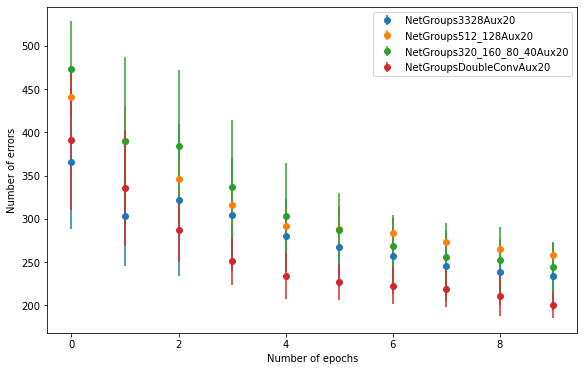

In [24]:
#To test the function
models=[NetGroups3328Aux20,NetGroups512_128Aux20,NetGroups320_160_80_40Aux20,NetGroupsDoubleConvAux20]
model_names=['NetGroups3328Aux20','NetGroups512_128Aux20','NetGroups320_160_80_40Aux20','NetGroupsDoubleConvAux20']
big_error_plot(models,model_names,n=5,nb_epochs=10,div=10,name="TestPlot.png")

In [ ]:
models=[NetGroups3328Aux20,NetGroups512_128Aux20,NetGroups320_160_80_40Aux20,NetGroupsDoubleConvAux20,NetGroups512_60DoubleConvAux20,NetGroups1408TripleConvAux20,NetGroups864QuadConvAux20,NetGroups1152QuadConvAux20_bis]
model_names=['NetGroups3328Aux20','NetGroups512_128Aux20','NetGroups320_160_80_40Aux20','NetGroupsDoubleConvAux20','NetGroups512_60DoubleConvAux20','NetGroups1408TripleConvAux20','NetGroups864QuadConvAux20','NetGroups1152QuadConvAux20_bis']
big_error_plot(models,model_names,n=100,nb_epochs=50,name='big_plot_aux=1.png')

Starting model NetGroups3328Aux20
Starting model NetGroups512_128Aux20
Starting model NetGroups320_160_80_40Aux20
Starting model NetGroupsDoubleConvAux20


Starting model NetGroups3328Aux20
Starting model NetGroups512_128Aux20
Starting model NetGroups320_160_80_40Aux20
Starting model NetGroupsDoubleConvAux20
Starting model NetGroups512_60DoubleConvAux20
Starting model NetGroups1408TripleConvAux20
Starting model NetGroups864QuadConvAux20
Starting model NetGroups1152QuadConvAux20_bis


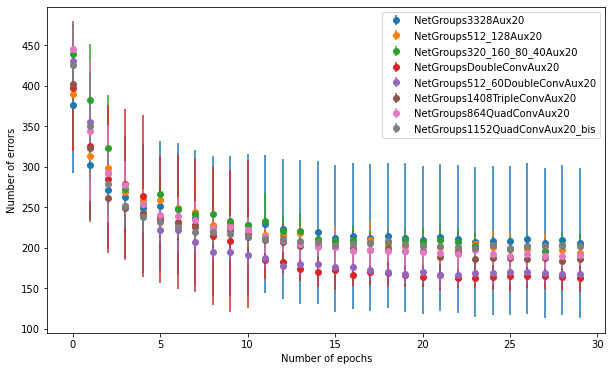

In [5]:
#Same as before with aux_factor=0.1
models=[NetGroups3328Aux20,NetGroups512_128Aux20,NetGroups320_160_80_40Aux20,NetGroupsDoubleConvAux20,NetGroups512_60DoubleConvAux20,NetGroups1408TripleConvAux20,NetGroups864QuadConvAux20,NetGroups1152QuadConvAux20_bis]
model_names=['NetGroups3328Aux20','NetGroups512_128Aux20','NetGroups320_160_80_40Aux20','NetGroupsDoubleConvAux20','NetGroups512_60DoubleConvAux20','NetGroups1408TripleConvAux20','NetGroups864QuadConvAux20','NetGroups1152QuadConvAux20_bis']
big_error_plot(models,model_names,n=100,nb_epochs=50,aux_factor=0.1,name='big_plot_aux=01.png')

Starting model NetGroups3328Aux20
Starting model NetGroups512_128Aux20
Starting model NetGroups320_160_80_40Aux20
Starting model NetGroupsDoubleConvAux20
Starting model NetGroups512_60DoubleConvAux20
Starting model NetGroups1408TripleConvAux20
Starting model NetGroups864QuadConvAux20
Starting model NetGroups1152QuadConvAux20_bis


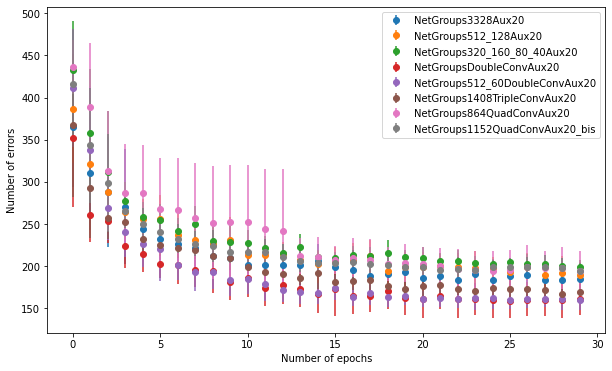

In [6]:
#Same as before with aux_factor=0
models=[NetGroups3328Aux20,NetGroups512_128Aux20,NetGroups320_160_80_40Aux20,NetGroupsDoubleConvAux20,NetGroups512_60DoubleConvAux20,NetGroups1408TripleConvAux20,NetGroups864QuadConvAux20,NetGroups1152QuadConvAux20_bis]
model_names=['NetGroups3328Aux20','NetGroups512_128Aux20','NetGroups320_160_80_40Aux20','NetGroupsDoubleConvAux20','NetGroups512_60DoubleConvAux20','NetGroups1408TripleConvAux20','NetGroups864QuadConvAux20','NetGroups1152QuadConvAux20_bis']
big_error_plot(models,model_names,n=100,nb_epochs=50,aux_factor=0,name='big_plot_aux=0.png')

Starting model NetGroups3328Aux20
Starting model NetGroups512_128Aux20
Starting model NetGroups320_160_80_40Aux20
Starting model NetGroupsDoubleConvAux20
Starting model NetGroups512_60DoubleConvAux20
Starting model NetGroups1408TripleConvAux20
Starting model NetGroups864QuadConvAux20
Starting model NetGroups1152QuadConvAux20_bis


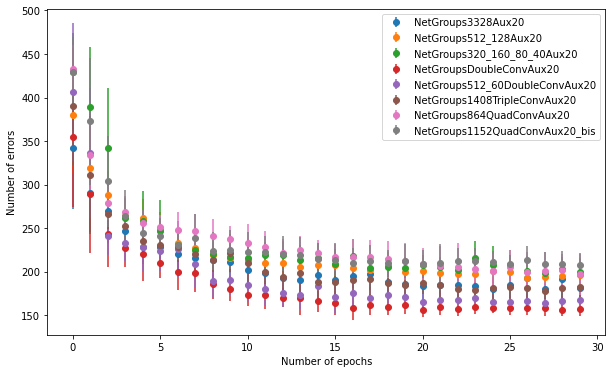

In [7]:
#Same as before with aux_factor=0.3
models=[NetGroups3328Aux20,NetGroups512_128Aux20,NetGroups320_160_80_40Aux20,NetGroupsDoubleConvAux20,NetGroups512_60DoubleConvAux20,NetGroups1408TripleConvAux20,NetGroups864QuadConvAux20,NetGroups1152QuadConvAux20_bis]
model_names=['NetGroups3328Aux20','NetGroups512_128Aux20','NetGroups320_160_80_40Aux20','NetGroupsDoubleConvAux20','NetGroups512_60DoubleConvAux20','NetGroups1408TripleConvAux20','NetGroups864QuadConvAux20','NetGroups1152QuadConvAux20_bis']
big_error_plot(models,model_names,n=100,nb_epochs=50,aux_factor=0.3,name='big_plot_aux=03.png')